# SSIF Correlation Analysis

### Run the code in a cell below by selecting it and clicking on the play button at the top
### For the code to run smoothly, run each cell in order

In [44]:
%matplotlib inline
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [63]:
def combine_ohlc(series):
    """
    Combines a dictionary of OHLC time series data into one DataFrame
    with a single column containing the close values of each series
    """
    c_data = series.copy()
    
    for i in c_data:        
        c_data[i] = c_data[i]["Adj Close"]
        c_data[i] = c_data[i].rename(i)
    for i, ticker in enumerate(c_data):
        if i == 0:
            total_data = pd.DataFrame(c_data[ticker], index = c_data[ticker].index)
        else:
            total_data = pd.merge(total_data, c_data[ticker], left_index = True, right_index = True)
        
    return total_data

### Enter the Ticker symbol of a stock below

In [244]:
# Enter the ticker symbol of the stock you're interested in
ticker = input("Enter the ticker symbol of the stock you're interested in: ")

Enter the ticker symbol of the stock you're interested in: ITW


In [91]:
fund_performance = pd.read_csv("FundPerformance.csv")

In [36]:
stock = yf.download(ticker, start = "2017-01-01")

[*********************100%***********************]  1 of 1 completed


In [92]:
# Prepping the data
fund_performance = fund_performance.set_index("Date")
fund_performance["SSIF Portfolio"] = fund_performance["SSIF Portfolio"]/100 + 1
fund_performance.index = pd.to_datetime(fund_performance.index)
combined_data = pd.merge(fund_performance["SSIF Portfolio"], stock["Adj Close"], left_index = True, right_index = True)

In [93]:
# Take log returns of daily price change
adj_data_1 = np.log(combined_data.iloc[1:]["SSIF Portfolio"].values/combined_data.iloc[:-1]["SSIF Portfolio"].values)
adj_data_2 = np.log(combined_data.iloc[1:]["Adj Close"].values/combined_data.iloc[:-1]["Adj Close"].values)

In [94]:
# More data prep
combined_data.loc[combined_data.index[1]:, "SSIF Portfolio"] = adj_data_1
combined_data.loc[combined_data.index[1]:, "Adj Close"] = adj_data_2
combined_data = combined_data.dropna().loc[combined_data.index[1]:,:]

In [95]:
print("Overall Correlation:", combined_data.corr()["SSIF Portfolio"]["Adj Close"])

Overall Correlation: 0.7056830476098894


In [96]:
# Calculate trailing 6-month correlation between the SSIF and the stock
times = combined_data.index
year = datetime.timedelta(days = 182)
corrs = []
for i in combined_data[times[0] + year:].index:
    corrs.append([i,combined_data[i - year:i].corr().iloc[0][1]])
corrs = np.array(corrs)

### Plotting correlation between SSIF's daily performance and stock

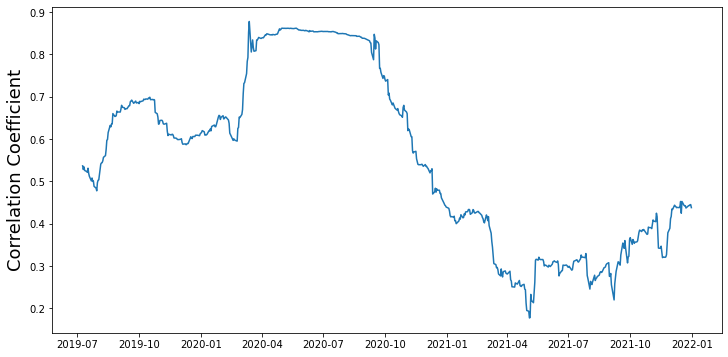

In [97]:
# Plot correlation coefficient over last 2.5 years
fig = plt.figure(figsize = (12,6))
ax = plt.axes()

ax.set_ylabel("Correlation Coefficient")
ax.yaxis.label.set_color("black")
ax.yaxis.label.set_size(18)

ax.tick_params(axis = 'x', colors = "black")
ax.tick_params(axis = 'y', colors = "black")

ax.plot(corrs[:,0], corrs[:,1]);

### Plotting stock's performance vs. SSIF's performance

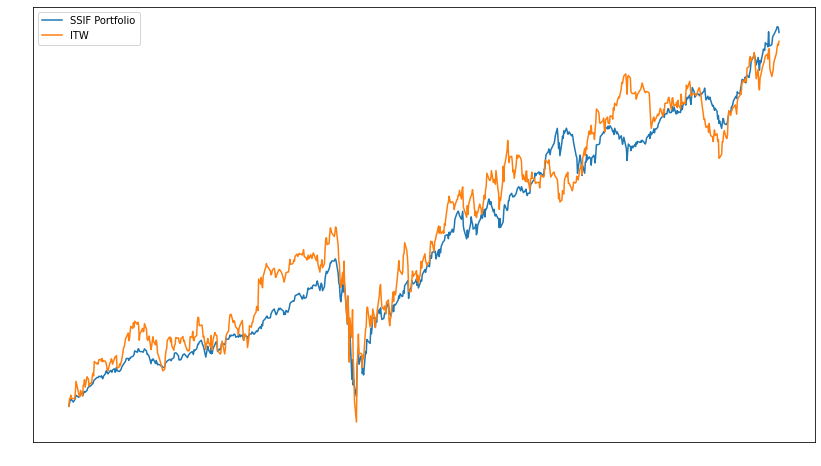

In [62]:
# Plot price chart of the SSIF and the stock
combined_data = pd.merge(fund_performance["SSIF Portfolio"], stock["Adj Close"], left_index = True, right_index = True)

fig = plt.figure(figsize = (14,8))
ax = plt.axes()

ax.tick_params(axis = 'x', colors = "black")
ax.tick_params(axis = 'y', colors = "black")

ax.plot(combined_data["SSIF Portfolio"]/(combined_data.iloc[0]["SSIF Portfolio"]/combined_data.iloc[0]["Adj Close"]), label = "SSIF Portfolio")
ax.plot(combined_data["Adj Close"], label = ticker)

leg = ax.legend();

## Analyze your stock against each of the SSIF's holdings individually

In [2]:
# Get list of SSIf's current holdings
holdings = pd.read_csv("SSIFHoldings.csv")

In [224]:
# Get daily stock price data for all the fund's holdings
holdings_price = {}
holdings_price[ticker] = stock
for i in holdings["Ticker"]:
    holdings_price[i] = yf.download(i, start = "2019-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [225]:
all_stock_data = combine_ohlc(holdings_price)

In [235]:
# Convert stock prices to log returns
for i in all_stock_data:
    all_stock_data.loc[all_stock_data.index[1]:,i] = np.log(all_stock_data.iloc[1:][i].values/all_stock_data.iloc[:-1][i].values)
all_stock_data = all_stock_data.loc[all_stock_data.index[1]:,:]

### Generate a heatmap of the correlations between stock and each of the fund's holdings

Take a look at the first column of the heatmap


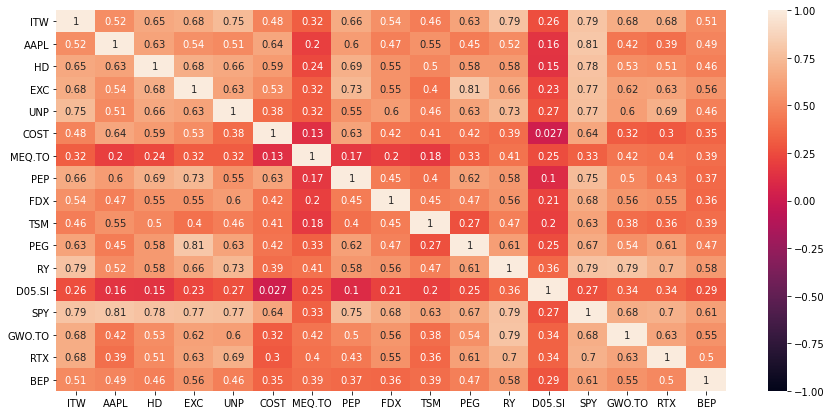

In [245]:
# Heatmap
fig = plt.figure(figsize = (15,7))
ax = plt.axes()

ax.tick_params(axis = 'x', colors = "black")
ax.tick_params(axis = 'y', colors = "black")

print("Take a look at the first column of the heatmap")
sns.heatmap(all_stock_data.corr(), annot = True, vmin = -1, vmax = 1);

In [240]:
# Calculate average correlation
print("Average Correlation:", all_stock_data.corr()["ITW"].mean())

Average Correlation: 0.611509251148936


### Calculate trailing 6-month correlation between each SSIF holding and the stock

In [241]:
# Calculate trailing 6-month correlation between each SSIF holding and the stock
times = all_stock_data.index
year = datetime.timedelta(days = 182)
corrs_all = []
for i in all_stock_data[times[0] + year:].index:
    day_corr = all_stock_data[i - year:i].corr()["ITW"].to_dict()
    day_corr = [[ticker, float(val)] for ticker, val in day_corr.items()]
    corrs_all.append([i,np.array(day_corr)])
corrs_all = np.asarray(corrs_all, dtype = object)

In [242]:
chosen_stock = input("Enter ticker symbol: ")
ind = 0
for i in range(len(corrs_all[:,1][0])):
    if corrs_all[:,1][0][i][0] == chosen_stock:
        ind = i
        break

Enter ticker symbol: AAPL


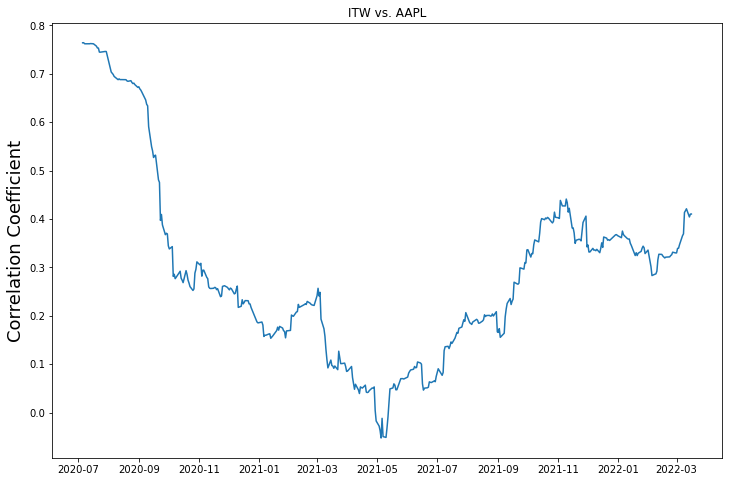

In [243]:
# Plot correlation coefficient over last 2 years
corr_series = [float(i[ind][1]) for i in corrs_all[:,1][:]]

fig, ax = plt.subplots(figsize = (12,8))

ax.plot(corrs_all[:,0], corr_series)

ax.set_ylabel("Correlation Coefficient")
ax.yaxis.label.set_color("black")
ax.yaxis.label.set_size(18)

ax.tick_params(axis = 'x', colors = "black")
ax.tick_params(axis = 'y', colors = "black")
ax.set(title = f"{ticker} vs. {corrs_all[:,1][:][0][ind][0]}");